In [1]:
import cv2
import torch
import random
import collections
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.transforms as transforms

In [2]:
class strLabelConverter(object):

    def __init__(self, alphabet):

        alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'

        self.dict = {}
        
        for i, char in enumerate(alphabet):
            
            self.dict[char] = i + 1      # Position 0 is for space character

    def encode(self, text):
        
        # Encoding the word into integer format.
        text = [self.dict[char.lower()]for char in text]
        length = [len(text)]
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):

        length = length[0]
        assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
        if raw:
            return ''.join([self.alphabet[i - 1] for i in t])
        else:
            char_list = []
            for i in range(length):
                if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                    char_list.append(self.alphabet[t[i] - 1])
            return ''.join(char_list)

In [3]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self):
        
        super(CRNN, self).__init__()
   
        cnn = nn.Sequential()
        cnn.add_module('conv0',      nn.Conv2d(1, 64, 3, 1, 1))  # Input, Output, Kernal, Stride, Padding
        cnn.add_module('relu0',      nn.ReLU(True))                
        cnn.add_module('pooling0',   nn.MaxPool2d(2, 2))                     # 64x16x64     
        cnn.add_module('conv1',      nn.Conv2d(64, 128, 3, 1, 1))
        cnn.add_module('relu1',      nn.ReLU(True))    
        cnn.add_module('pooling1',   nn.MaxPool2d(2, 2))                     # 128x8x32  
        cnn.add_module('conv2',      nn.Conv2d(128, 256, 3, 1, 1))
        cnn.add_module('batchnorm2', nn.BatchNorm2d(256))
        cnn.add_module('relu2',      nn.ReLU(True))   
        cnn.add_module('conv3',      nn.Conv2d(256, 256, 3, 1, 1))
        cnn.add_module('relu3',      nn.ReLU(True))     
        cnn.add_module('pooling2',   nn.MaxPool2d((2, 2), (2, 1), (0, 1)))   # 256x4x16   
        cnn.add_module('conv4',      nn.Conv2d(256, 512, 3, 1, 1))
        cnn.add_module('batchnorm4', nn.BatchNorm2d(512))
        cnn.add_module('relu4',      nn.ReLU(True))    
        cnn.add_module('conv5',      nn.Conv2d(512, 512, 3, 1, 1))
        cnn.add_module('relu5',      nn.ReLU(True))  
        cnn.add_module('pooling3',   nn.MaxPool2d((2, 2), (2, 1), (0, 1)))   # 512x2x16   
        cnn.add_module('conv6',      nn.Conv2d(512, 512, 2, 1, 0))           # 512x1x16
        cnn.add_module('batchnorm6', nn.BatchNorm2d(512))
        cnn.add_module('relu6',      nn.ReLU(True))
          
        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, 256, 256),       # Input, Hidden, Output
            BidirectionalLSTM(256, 256, 37))        # Final output: 37 classes

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [4]:
class resizeNormalize(object):

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        return img

In [5]:
def predict(image_name):

    model_path = './model/crnn.pth'
    img_path = './data/' + image_name
    alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'

    model = CRNN()
    if torch.cuda.is_available():
        model = model.cuda()
        
    # print('loading pretrained model from %s' % model_path)
    model.load_state_dict(torch.load(model_path)) 
    converter = strLabelConverter(alphabet)

    transformer = resizeNormalize((100, 32))
    image = Image.open(img_path).convert('L')
    image = transformer(image)
    if torch.cuda.is_available():
        image = image.cuda()
    image = image.view(1, *image.size())
    image = Variable(image)

    model.eval()
    preds = model(image)

    # x is maximum value out of 37 characters and preds is corresponding alphabet
    x, preds = preds.max(2)

    preds = preds.transpose(1, 0).contiguous().view(-1)

    preds_size = Variable(torch.IntTensor([preds.size(0)]))
    raw_pred = converter.decode(preds.data, preds_size.data, raw=True)    # 26 prediction by each output layer
    sim_pred = converter.decode(preds.data, preds_size.data, raw=False)   # clean prediction
    print('%s   ==>   %s' %(raw_pred, sim_pred))
    return sim_pred

In [6]:
def load_image(name):  
    
    image = cv2.imread("data/" + name, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (1280, 720))

    plt.imshow(image)
    print(image.shape)
    print("Original Frame:")   
    return image

(720, 1280)
Original Frame:


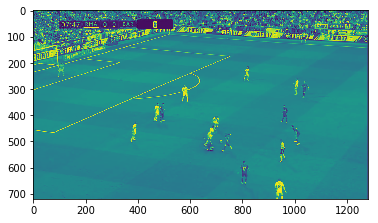

In [23]:
image = load_image("demo.png")

In [24]:
def crop(box, name, img):
    
    image = img
    crop_img = image[box[0]:box[1], box[2]:box[3]]
    plt.imshow(crop_img)
    print(crop_img.shape)

    cv2.imwrite('data/' + name, crop_img)

(27, 77)


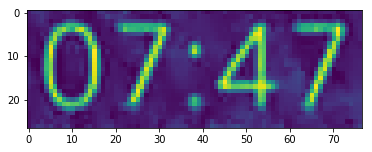

In [25]:
time_box  = [43, 70, 105, 182]
score_box = [43, 70, 257, 327]
team1_box = [43, 70, 190, 250]
team2_box = [43, 70, 335, 390]

crop(time_box, "time.png", image)

(27, 70)


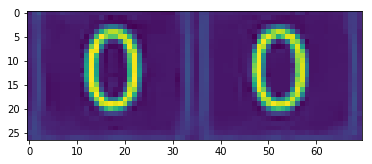

In [26]:
crop(score_box, "score.png", image)

(27, 60)


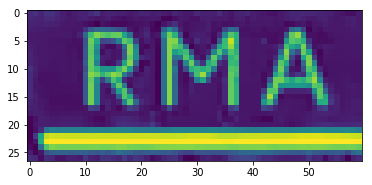

In [27]:
crop(team1_box, "team1.png", image)

(27, 55)


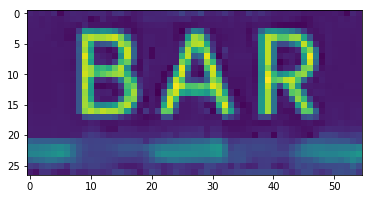

In [28]:
crop(team2_box, "team2.png", image)

In [29]:
time = predict("time.png")

if len(time) == 5:
    time = time[:2] + time[3:]
    
time = time[:2] + ":" + time[2:]    

team1 = predict("team1.png")
team2 = predict("team2.png")
score = predict("score.png")

if len(score) == 3:
    score = score[:1] + score[2:]

score = score[:1] + "-" + score[1:]   

0-------7------4-----7----   ==>   0747
r-----------m------a------   ==>   rma
bb---------aa-----r-------   ==>   bar
0-----------------0-------   ==>   00


In [30]:
print("Time:       ", time)
print("Team 1:     ", team1)
print("Team 2:     ", team2)
print("Score:      ", score)

Time:        07:47
Team 1:      rma
Team 2:      bar
Score:       0-0
